In this notebook, we use a trained convnet to forecast mortality in the future. Since we want to prioritize complete data coverage, we will treat NAs differently here. Instead of dropping NA windows, we will gapfill using the running mean of the batchnorm layer.

In [1]:
import torch
import xarray as xr
import numpy as np
import rioxarray

import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util

### Get data

In [2]:
ds = xr.open_dataset("data_working/westmort.nc")
ds

<xarray.Dataset> Size: 457MB
Dimensions:      (x: 590, y: 652, time: 27)
Coordinates:
  * x            (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y            (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time         (time) int64 216B 1997 1998 1999 2000 ... 2020 2021 2022 2023
Data variables:
    vod          (time, y, x) float32 42MB ...
    elev         (time, y, x) float32 42MB ...
    slope        (time, y, x) float32 42MB ...
    northness    (time, y, x) float32 42MB ...
    eastness     (time, y, x) float32 42MB ...
    fire         (time, y, x) float32 42MB ...
    mortality    (time, y, x) float32 42MB ...
    prcp         (time, y, x) float32 42MB ...
    vp           (time, y, x) float32 42MB ...
    tmin         (time, y, x) float32 42MB ...
    treecover    (time, y, x) float32 42MB ...
    spatial_ref  int64 8B ...

### Get model

In [3]:
from util.convlstm import DamageConvLSTM

path = "logs/20250211_theta_tuning/convlstm__8_8_5__mort_fire_ppt__theta0.00/model.pth"

# TODO find a better way to translate these constants
# instead of copy-pasting.
input_channel = 3
hidden_dim = 16
num_layers = 3
kernel = (3, 3)
m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True)
m.load_state_dict(torch.load(path, weights_only=True))
m.eval() # Turn off dropout, use global batchnorm stats, etc.

DamageConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (drop): Dropout(p=0, inplace=False)
      )
      (1-2): 2 x ConvLSTMCell(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (drop): Dropout(p=0, inplace=False)
      )
    )
  )
  (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
  (bn): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Dataloader

Since we don't need absolutely complete data, do inference on windows with at least 50% valid data. Fire and precip never have NAs, so we can use the mortality band as the mask variable.

In [4]:
window = dict(x=[8, False], y=[8, False], time=[4, False])
input_arr = ds[["fire", "mortality", "prcp"]]\
    .to_stacked_array(new_dim="band", sample_dims=["x", "y", "time"])\
    .isel(time=slice(-5, -1))
input_ds = util.datasets.WindowXarrayDataset(input_arr, window, mask=input_arr.isel(band=1), na_thresh=0.5)

In [5]:
print(len(input_ds))

123426


In [6]:
channel_means = m.bn.running_mean
def preprocess(patch):
    # (T, H, W, C) --> (1, T, C, H, W)
    return torch.tensor(patch.values).permute(0, 3, 1, 2).unsqueeze(0)

In [7]:
from tqdm import tqdm

eps = 1e-3

output_arr = np.zeros(input_arr.shape[1:3]) + np.log10(eps)
output_n   = np.zeros(input_arr.shape[1:3])

for i in tqdm(range(len(input_ds)), leave=False):
    # Get data
    patch = preprocess(input_ds[i])

    # Pass to model and convert to logits
    out = m(patch).detach().cpu().numpy()
    out[out < eps] = eps
    out = np.log10(out)

    # Write to output array
    xmax = input_ds.valid_indices["x"][i]
    ymax = input_ds.valid_indices["y"][i]

    output_arr[ymax-7:ymax+1, xmax-7:xmax+1] += out[0, ...]
    output_n[ymax-7:ymax+1, xmax-7:xmax+1] += 1

In [8]:
output_avg = output_arr / output_n
output_avg[~np.isfinite(output_avg)] = np.nan
output_pct = np.pow(10, output_avg)

/tmp/ipykernel_958/75608825.py:1: RuntimeWarning: divide by zero encountered in divide
  output_avg = output_arr / output_n


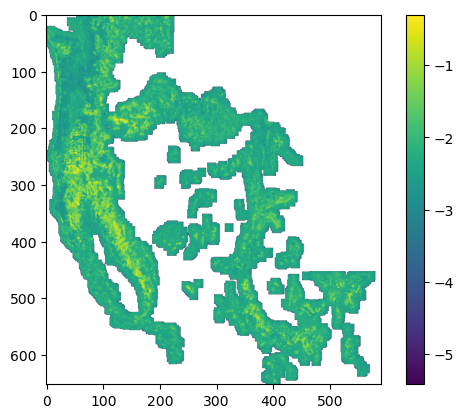

In [9]:
from matplotlib import pyplot as plt
plt.imshow(output_avg)
plt.colorbar()
plt.show()

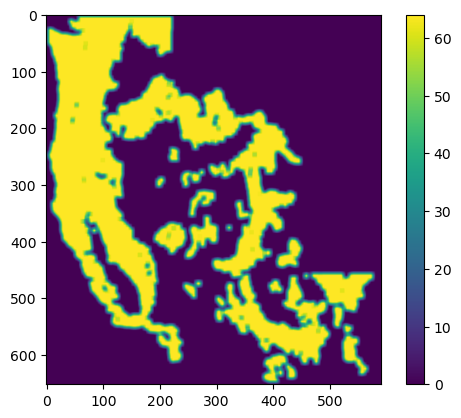

In [10]:
plt.imshow(output_n)
plt.colorbar()
plt.show()

In [11]:
output_da = xr.DataArray(
    data=output_pct,
    dims=["y", "x"],
    coords={"y": ds.y, "x": ds.x, "time": 2023}
)

In [12]:
ds["prediction"] = output_da

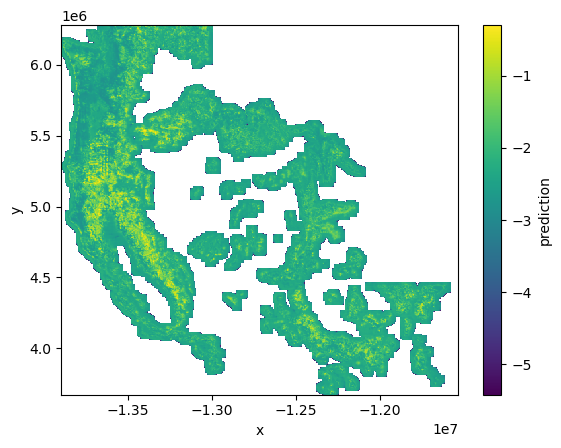

In [13]:
np.log10(ds["prediction"]).plot()

In [14]:
output_da.rio.to_raster("data_out/2022_prediction.tif")